In [20]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

Load data for the 2D Ising model, which we generated using `python example_2DIsing.py`. N=25, and samples B=6e3

In [21]:
file = './2DIsing_example.hdf5'
group = '2d_ising_N25'

with h5py.File(file, 'r') as fin:
    print(fin[group].keys())
    in_models = fin[group + '/inputModels'][()]  # input models
    in_datasets = fin[group + '/configurations'][()]  # data generated from Monte Carlo Simulation

    plm_models = fin[group + '/inferredModels'][()] # PLM inferred models
    firth_models = fin[group + '/firthModels'][()]  # PLM with Firth's Penalty
    c2_models = fin[group + '/c2Models'][()] # Self-Consistency corrected PLM models

    mod_md = fin[group + '/inputModels_metadata'].asstr()[()]
    sim_md = fin[group + '/configurations_metadata'].asstr()[()]

    # loading temp sweep data
    temps = fin[group + '/sweep-temps'][()]
    sweep_trajectories = fin[group + '/sweep-trajectories'][()] 
    
    print(mod_md)
    print(sim_md)

    print(in_models.shape)

<KeysViewHDF5 ['c2Models', 'c2Models_metadata', 'configurations', 'configurations_metadata', 'firthModels', 'firthModels_metadata', 'inferredModels', 'inferredModels_metadata', 'inputModels', 'inputModels_metadata', 'sweep-temps', 'sweep-trajectories']>
["{'model': '2D_ISING_PBC', 'L': 5, 'T': 2.5, 'h': 0, 'jval': 1}"]
["{'B_eq': 2000.0, 'B_sample': 1000.0, 'nChains': 6}"]
(1, 25, 25)


Now that data is loaded let's compare what input and inferred models look like. Note shape of models is currently (1, 25, 25), as pipeline was only asked to generate a single input model. PyPLM can handle multiple input models. Input model were generated at $T=2.5$, so we expect connected spins to have a coupling strength of $J=1/T=0.4$ .

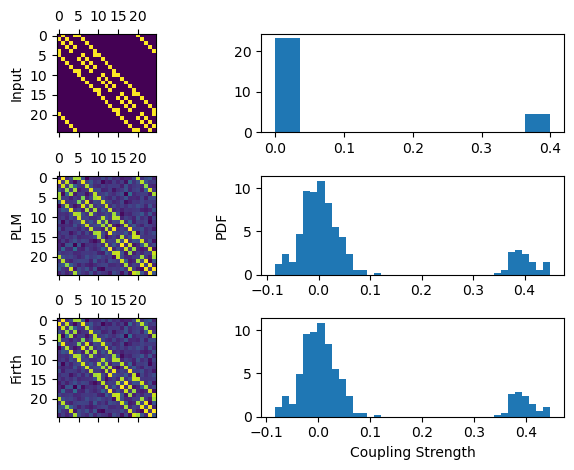

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=2)
ax[0, 0].matshow(in_models[0, :, :])
ax[1, 0].matshow(plm_models[0, :, :])
ax[2, 0].matshow(firth_models[0, :, :])

ax[0, 1].hist(in_models[0, :, :].ravel(), density=True, bins='auto')
ax[1, 1].hist(plm_models[0, :, :].ravel(), density=True, bins='auto')
ax[2, 1].hist(firth_models[0, :, :].ravel(), density=True, bins='auto')

ax[0, 0].set(ylabel='Input')
ax[1, 0].set(ylabel='PLM')
ax[2, 0].set(ylabel='Firth')

ax[1, 1].set(ylabel='PDF')
ax[2, 1].set(xlabel='Coupling Strength')

plt.tight_layout()
plt.show()

PLM correctly reproduces network structure from the data, and correctly predicts the connection strength (0.4). PyPLM also allows you to perform temperature sweeps of your data, to understand where in it is positioned in relation to any phase transitions. We performed this using the `plm_pipeline.ficticiousT_sweep` method. We can specify the model we would like to sweep using the argument `mod_name`; the default is to sweep the plm inferred models, `mod_name='inferredModels`. Both `firthModels`, and `inputModels` are also valid choices. The example below is for:
```
plm_pipeline.ficticiousT_sweep(
    temps=np.linspace(0.1, 3, 100), # how many temperatures to sweep
    nSamples=5e3, # how may samples to collect from each Monte Carlo simulation at each temperature
    nChains=6, # how many independent Monte Carlo chains to simulate at each temperature
    mod_name='inferredModels'5e3, # which model to simulate
    )
```

We will track the magnetization and susceptibility of the inferred model below.

(100,)
(1, 100, 6, 5000, 25)


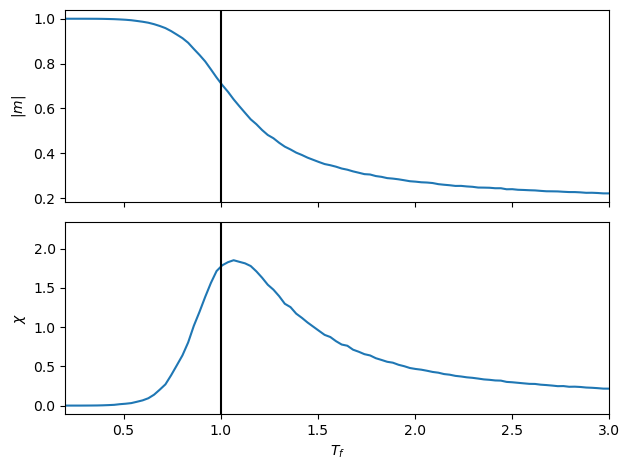

In [34]:
print(temps.shape)
print(sweep_trajectories.shape)

def m_trajectory(repeat_trajectories):
    nR, B, N = repeat_trajectories.shape
    ms = np.zeros(nR)
    chis = np.zeros(nR)
    for iR in range(0, nR):
        traj = repeat_trajectories[iR, :, :]
        m_traj = np.abs(np.mean(traj, axis=1))
        # print(traj.shape, m_traj.shape)
        ms[iR] = np.mean(m_traj)
        chis[iR] = np.var(m_traj)
    return np.mean(ms), np.mean(chis)

ms = np.zeros(temps.size)
chis = np.zeros(temps.size)
for i in range(0, temps.size):
    m, chi = m_trajectory(sweep_trajectories[0, i, :, :, :])
    ms[i] = m
    chis[i] = chi
chis = (chis/temps) * 25

fig, ax  = plt.subplots(nrows=2, ncols=1, squeeze=False, sharex=True)
ax[0, 0].plot(temps, ms)
ax[1, 0].plot(temps, chis)

ax[0, 0].axvline(1, c='k')
ax[1, 0].axvline(1, c='k')

ax[0, 0].set(ylabel=r'$|m|$')
ax[1, 0].set(ylabel=r'$\chi$', xlabel=r'$T_f$', xlim=[0.2, 3.0])
plt.tight_layout()
plt.show()



The 2D Ising model has a phase transition at $T=2.269$ for $N \to \infty$ . The input model we generated as at $T=2.5$, close to this transition. As inferred model shows a transition near $T_f=1$, we conclude the near-critical nature of the input model has been captured.